#Setting up

In [ ]:
! pip install -q -U datasets
! pip install -q transformers -U
! pip install -q transformers[torch] -U
! pip install -q sentencepiece
! pip install -q evaluate
! pip install -q bert_score
! pip install -q -U accelerate
! pip install -q peft
! pip install -q -U huggingface-hub
! pip install -q sentence-transformers
! pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import wandb

wandb.login()

#Load dataset

In [ ]:
from datasets import load_dataset

# dataset_name = "minh21/COVID-QA-sentence-Question-Answering-Transformer-data"
dataset_name = "minh21/COVID-QA-Chunk-64-question-answering-biencoder-data-90_10"
dataset = load_dataset(dataset_name, use_auth_token=True)

# test_set_name = "minh21/COVID-QA-testset-data"
test_set_name = "minh21/COVID-QA-Chunk-64-testset-biencoder-data-90_10"
dataset["test"] = load_dataset(test_set_name, use_auth_token=True, split="train")

dataset = dataset.remove_columns(["id"])

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2089: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=True' instead.
  warnings.warn(


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1631 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/185 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2089: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=True' instead.
  warnings.warn(


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/203 [00:00<?, ? examples/s]

In [ ]:
from sentence_transformers import SentenceTransformer, util, CrossEncoder

# st_model_nm = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
# bi_encoder = SentenceTransformer(st_model_nm)
# bi_encoder.max_seq_length = 256  # Truncate long passages to 256 tokens
top_k = 7  # Number of passages we want to retrieve with the bi-encoder
top_k_ce = 3
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

In [ ]:
# cross encoder
def retrieve_context(row):
    query = row["question"]

    # cross-encoder
    hits = [{"corpus_id": i} for i in range(len(row["context_chunks"]))]
    cross_inp = [[query, row["context_chunks"][hit["corpus_id"]]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp, show_progress_bar=False)

    for idx in range(len(cross_scores)):
        hits[idx]["cross-score"] = cross_scores[idx]

    hits = sorted(hits, key=lambda x: x["cross-score"], reverse=True)

    row["retrieved_context"] = " ".join(
        [row["context_chunks"][hit["corpus_id"]] for hit in hits[0:top_k]]
    ).replace("\n", " ")

    return row

In [ ]:
dataset = dataset.map(retrieve_context, batched=False)

Map:   0%|          | 0/1631 [00:00<?, ? examples/s]

Map:   0%|          | 0/185 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

In [ ]:
match = 0


def find_match(row):
    global match
    match = match + (1 if row["answer"] in row["retrieved_context"] else 0)

In [ ]:
match = 0
dataset["train"].map(find_match, batched=False)
print("Train: %.2f" % (match / dataset["train"].num_rows * 100))

match = 0
dataset["validation"].map(find_match, batched=False)
print("Validation: %.2f" % (match / dataset["validation"].num_rows * 100))

match = 0
dataset["test"].map(find_match, batched=False)
print("Test: %.2f" % (match / dataset["test"].num_rows * 100))

Map:   0%|          | 0/1631 [00:00<?, ? examples/s]

Train: 89.45


Map:   0%|          | 0/185 [00:00<?, ? examples/s]

Validation: 90.81


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Test: 93.60


In [ ]:
dataset["test"] = dataset["test"].remove_columns(["context"])
dataset = dataset.rename_columns({"retrieved_context": "context"})

In [ ]:
dataset.save_to_disk("./covid-qa-ce")

In [ ]:
from datasets import DatasetDict

dataset = DatasetDict.load_from_disk("./covid-qa-ce-100%")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context_chunks', 'document_id', 'context'],
        num_rows: 1631
    })
    validation: Dataset({
        features: ['question', 'answer', 'context_chunks', 'document_id', 'context'],
        num_rows: 185
    })
    test: Dataset({
        features: ['question', 'answer', 'context_chunks', 'document_id', 'context'],
        num_rows: 203
    })
})

In [ ]:
dataset["train"] = dataset["train"].filter(lambda row: row["answer"] in row["context"])
dataset["validation"] = dataset["validation"].filter(
    lambda row: row["answer"] in row["context"]
)
dataset

Filter:   0%|          | 0/1631 [00:00<?, ? examples/s]

Filter:   0%|          | 0/185 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'context_chunks', 'document_id', 'context'],
        num_rows: 1459
    })
    validation: Dataset({
        features: ['question', 'answer', 'context_chunks', 'document_id', 'context'],
        num_rows: 168
    })
    test: Dataset({
        features: ['question', 'answer', 'context_chunks', 'document_id', 'context'],
        num_rows: 203
    })
})

#Load Original Model

In [ ]:
model_nm = "google/flan-t5-large"
max_length = 512
max_target_length = 200
checkpoint = "flan-t5-lora-tuning-covidqa2"
username = "checkiejan"

In [ ]:
import evaluate


def evaluate_qa(predicted_result):

    squad_metric = evaluate.load("squad")
    predictions = [
        {"prediction_text": answer, "id": str(id)}
        for id, answer in enumerate(predicted_result["output"])
    ]
    references = [
        {
            "answers": {"answer_start": [-1], "text": [ds["answer"]]},
            "id": str(id),
        }
        for id, ds in enumerate(predicted_result)
    ]
    results = {}
    results["squad"] = squad_metric.compute(
        predictions=predictions, references=references
    )

    predictions = predicted_result["output"]
    references = predicted_result["answer"]

    bleu_metrics = evaluate.load("bleu")
    results["bleu"] = bleu_metrics.compute(
        predictions=predictions, references=references
    )

    bertscore_metric = evaluate.load("bertscore")
    berscore = bertscore_metric.compute(
        predictions=predictions, references=references, lang="en"
    )
    results["bertscore"] = {
        "precision": sum(berscore["precision"]) / len(berscore["precision"]),
        "recall": sum(berscore["recall"]) / len(berscore["recall"]),
        "f1": sum(berscore["f1"]) / len(berscore["f1"]),
    }

    return results

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

tokenizer = AutoTokenizer.from_pretrained(model_nm, device_map="auto")
model = AutoModelForSeq2SeqLM.from_pretrained(model_nm, device_map="auto")

In [ ]:
def interfere(ds):
    ds["input"] = f"question: {ds['question']} " f"context: {ds['context']}"
    input_ids = tokenizer(
        ds["input"],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_length,
    ).input_ids.to(torch.device("cuda"))
    outputs = model.generate(input_ids, max_new_tokens=max_target_length)
    ds["output"] = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return ds


model.eval()
with torch.no_grad():
    predicted_result = dataset["test"].map(interfere, batched=False)

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

In [ ]:
evaluate_qa(predicted_result)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'squad': {'exact_match': 17.24137931034483, 'f1': 42.707544905141745},
 'bleu': {'bleu': 0.321531393609968,
  'precisions': [0.3831680650902619,
   0.3201072386058981,
   0.30172170476996896,
   0.288803317535545],
  'brevity_penalty': 1.0,
  'length_ratio': 1.0181206316334455,
  'translation_length': 3933,
  'reference_length': 3863},
 'bertscore': {'precision': 0.8835275519657605,
  'recall': 0.882837537474233,
  'f1': 0.8822053591606065}}

#LoRa Model

In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_int8_training, TaskType

# Define LoRA Config
lora_config = LoraConfig(
    r=24,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)


# add LoRA adaptor
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 7,077,888 || all params: 790,227,968 || trainable%: 0.8956767270479599


In [ ]:
from transformers import DataCollatorForSeq2Seq

# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8,
    return_tensors="pt",
)

In [ ]:
def qa_prompt_preprocess(ds):
    input = f"question: {ds['question']} " f"context: {ds['context']}"
    model_inputs = tokenizer(input, max_length=max_length, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(
        text_target=ds["answer"], max_length=max_target_length, truncation=True
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


seq2seq_dataset = {
    "train": dataset["train"].map(qa_prompt_preprocess, batched=False),
    "test": dataset["validation"].map(qa_prompt_preprocess, batched=False),
}

Map:   0%|          | 0/1459 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

In [ ]:
seq2seq_dataset["train"] = seq2seq_dataset["train"].remove_columns(
    ["answer", "document_id", "context_chunks", "question", "context"]
)
seq2seq_dataset["test"] = seq2seq_dataset["test"].remove_columns(
    ["answer", "document_id", "context_chunks", "question", "context"]
)

<Axes: >

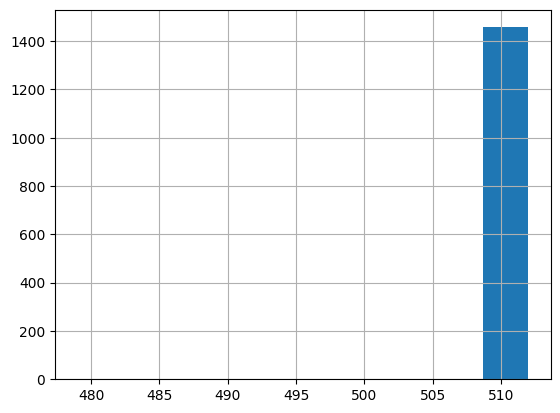

In [ ]:
import pandas as pd

df = pd.DataFrame(seq2seq_dataset["train"])
df["input_ids"].apply(len).hist()

#Train Model

In [ ]:
squad_metric = evaluate.load("squad")
bleu_metrics = evaluate.load("bleu")


def compute_metrics(pred):
    labels_ids, pred_ids = pred

    pred_ids[pred_ids == -100] = tokenizer.pad_token_id
    predictions = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    references = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    squad_predictions = [
        {"prediction_text": answer, "id": str(id)}
        for id, answer in enumerate(predictions)
    ]
    squad_references = [
        {
            "answers": {"answer_start": [-1], "text": [answer]},
            "id": str(id),
        }
        for id, answer in enumerate(references)
    ]
    results = {}
    results["squad"] = squad_metric.compute(
        predictions=squad_predictions, references=squad_references
    )

    results["bleu"] = bleu_metrics.compute(
        predictions=predictions, references=references
    )

    return results

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

output_dir = f"./{checkpoint}"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3,  # higher learning rate
    num_train_epochs=5,
    logging_dir=f"{output_dir}/logs",
    logging_strategy="steps",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    save_strategy="no",
    predict_with_generate=True,
    report_to="wandb",
    generation_max_length=max_target_length,
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=seq2seq_dataset["train"],
    eval_dataset=seq2seq_dataset["test"],
    compute_metrics=compute_metrics,
)
# model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Squad,Bleu
100,0.459100,0.501473,"{'exact_match': 32.73809523809524, 'f1': 65.0464786162307}","{'bleu': 0.4218739786007447, 'precisions': [0.47751605995717344, 0.4288939051918736, 0.40380047505938244, 0.3830242510699001], 'brevity_penalty': 1.0, 'length_ratio': 1.4054170249355116, 'translation_length': 3269, 'reference_length': 2326}"
200,0.441600,0.464787,"{'exact_match': 26.785714285714285, 'f1': 61.92925524955209}","{'bleu': 0.4327873343126691, 'precisions': [0.5940654634444784, 0.5520799742018704, 0.5327451645741432, 0.5164051355206848], 'brevity_penalty': 0.7896560197063993, 'length_ratio': 0.8089581786686464, 'translation_length': 3269, 'reference_length': 4041}"
300,0.465900,0.479277,"{'exact_match': 32.142857142857146, 'f1': 64.86069474288959}","{'bleu': 0.5196484989049672, 'precisions': [0.5680636280208015, 0.5240245082231538, 0.503562945368171, 0.4864479315263909], 'brevity_penalty': 1.0, 'length_ratio': 1.01616412806963, 'translation_length': 3269, 'reference_length': 3217}"
400,0.468000,0.457857,"{'exact_match': 34.523809523809526, 'f1': 63.944706150644045}","{'bleu': 0.39027859592048003, 'precisions': [0.44080758641786477, 0.3966462431473718, 0.37393959959280626, 0.35485021398002853], 'brevity_penalty': 1.0, 'length_ratio': 1.6361361361361362, 'translation_length': 3269, 'reference_length': 1998}"
500,0.464300,0.491183,"{'exact_match': 32.73809523809524, 'f1': 62.896357261934}","{'bleu': 0.35494004936282614, 'precisions': [0.40624044050168245, 0.36343115124153497, 0.33831014591109604, 0.3177603423680456], 'brevity_penalty': 1.0, 'length_ratio': 1.8262569832402236, 'translation_length': 3269, 'reference_length': 1790}"
600,0.383800,0.472600,"{'exact_match': 30.357142857142858, 'f1': 63.131345662606904}","{'bleu': 0.42221795781356447, 'precisions': [0.4750688283878862, 0.4298613350532086, 0.40515778758059046, 0.38409415121255347], 'brevity_penalty': 1.0, 'length_ratio': 1.1900254823443757, 'translation_length': 3269, 'reference_length': 2747}"
700,0.512400,0.472826,"{'exact_match': 29.761904761904763, 'f1': 61.317433174375495}","{'bleu': 0.4622986355206295, 'precisions': [0.5154481492811257, 0.46662366978394065, 0.4448591788259247, 0.4268901569186876], 'brevity_penalty': 1.0, 'length_ratio': 1.2491402369124953, 'translation_length': 3269, 'reference_length': 2617}"
800,0.297600,0.504403,"{'exact_match': 30.952380952380953, 'f1': 64.36478282502496}","{'bleu': 0.49411401215332823, 'precisions': [0.5490975833588253, 0.4995162850693325, 0.4760773668137089, 0.456490727532097], 'brevity_penalty': 1.0, 'length_ratio': 1.068649885583524, 'translation_length': 3269, 'reference_length': 3059}"
900,0.377400,0.497760,"{'exact_match': 35.11904761904762, 'f1': 65.22307773572277}","{'bleu': 0.4012527296291009, 'precisions': [0.4539614561027837, 0.40986778458561757, 0.38411944350186633, 0.36269614835948644], 'brevity_penalty': 1.0, 'length_ratio': 1.5559257496430272, 'translation_length': 3269, 'reference_length': 2101}"
1000,0.340000,0.485126,"{'exact_match': 29.166666666666668, 'f1': 60.77012147962966}","{'bleu': 0.3235578044641969, 'precisions': [0.37687366167023556, 0.3331183489197033, 0.3067526297930098, 0.2845934379457917], 'brevity_penalty': 1.0, 'length_ratio': 2.0291744258224704, 'translation_length': 3269, 'reference_length': 1611}"


TrainOutput(global_step=3650, training_loss=0.29383021877236565, metrics={'train_runtime': 3792.0043, 'train_samples_per_second': 1.924, 'train_steps_per_second': 0.963, 'total_flos': 1.7195244447596544e+16, 'train_loss': 0.29383021877236565, 'epoch': 5.0})

In [ ]:
model.push_to_hub("checkiejan/flan-t5-lora-covidqa")

adapter_model.bin:   0%|          | 0.00/28.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/checkiejan/flan-t5-lora-covidqa/commit/f7a2512727a6345638402c8b334c384e73117be8', commit_message='Upload model', commit_description='', oid='f7a2512727a6345638402c8b334c384e73117be8', pr_url=None, pr_revision=None, pr_num=None)

#Load Model from Huggingface

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# peft_model_id = "checkiejan/cpgqa-prefix-results"
peft_model_id = "checkiejan/flan-t5-lora-covidqa"
config = PeftConfig.from_pretrained(peft_model_id)

test_model = AutoModelForSeq2SeqLM.from_pretrained(
    config.base_model_name_or_path, device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(
    config.base_model_name_or_path, device_map="auto"
)

test_model = PeftModel.from_pretrained(test_model, peft_model_id)

In [ ]:
# Evaluate

In [ ]:
import torch


def interfere_prompt(ds):
    qa_input = f"question: {ds['question']} " f"context: {ds['context']}"
    input_ids = tokenizer(
        qa_input,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    ).to(torch.device("cuda"))
    outputs = model.generate(**input_ids, max_new_tokens=max_target_length)
    ds["output"] = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return ds


model.eval()
with torch.no_grad():
    predicted_result = dataset["test"].map(interfere_prompt, batched=False)

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

In [ ]:
evaluate_qa(predicted_result)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'squad': {'exact_match': 42.857142857142854, 'f1': 75.75022877969035},
 'bleu': {'bleu': 0.6121668301843662,
  'precisions': [0.7898505603985057,
   0.751412429378531,
   0.7358356940509915,
   0.7233722243131351],
  'brevity_penalty': 0.8165415666601229,
  'length_ratio': 0.8314781258089567,
  'translation_length': 3212,
  'reference_length': 3863},
 'bertscore': {'precision': 0.9534960309860154,
  'recall': 0.9437302477254069,
  'f1': 0.9480443206326715}}